In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb='/Users/jackmcmahon/Development/CHEM 101.6/CHEM101.6/Exercise4/Villin_Lab/2F4K.protein.pdb'
trajectory='/Users/jackmcmahon/Development/CHEM 101.6/CHEM101.6/Exercise4/Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='/Users/jackmcmahon/Development/CHEM 101.6/CHEM101.6/Exercise4/Villin_Lab/2f4K.xray.CA.pdb'
outdir='/Users/jackmcmahon/Development/CHEM 101.6/CHEM101.6/Exercise4/outdir'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)



outdir: /Users/jackmcmahon/Development/CHEM 101.6/CHEM101.6/Exercise4/outdir
pdb: /Users/jackmcmahon/Development/CHEM 101.6/CHEM101.6/Exercise4/Villin_Lab/2F4K.protein.pdb
trjaectory: /Users/jackmcmahon/Development/CHEM 101.6/CHEM101.6/Exercise4/Villin_Lab/2F4K.protein.s10.dcd


In [3]:
stride_sel=5
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 12559

Starting frame: 0

Last frame: 12559

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'A

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [6]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


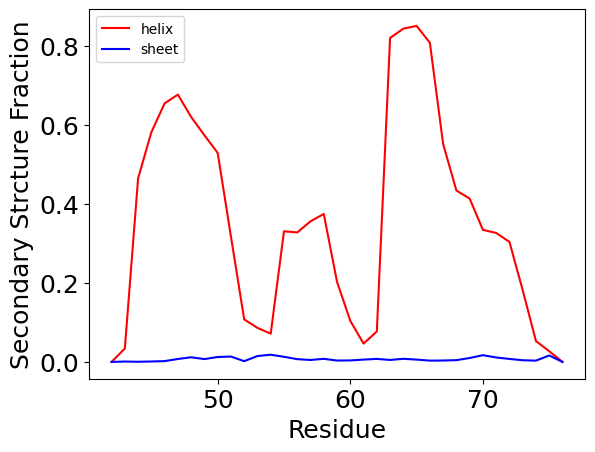

In [8]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [9]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [10]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [11]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




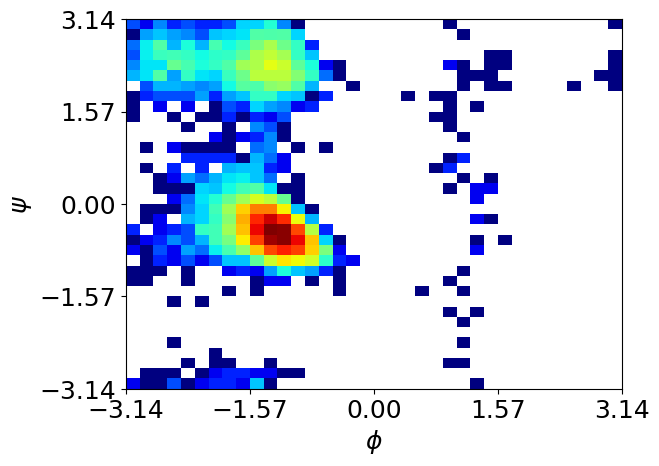

In [14]:
plot_phipsi(45)


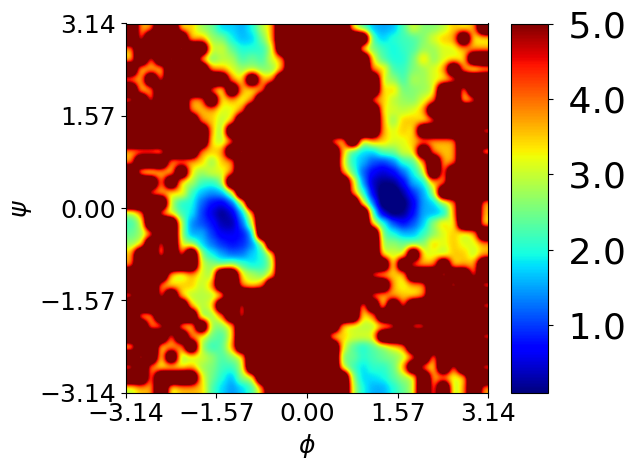

In [12]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(52)

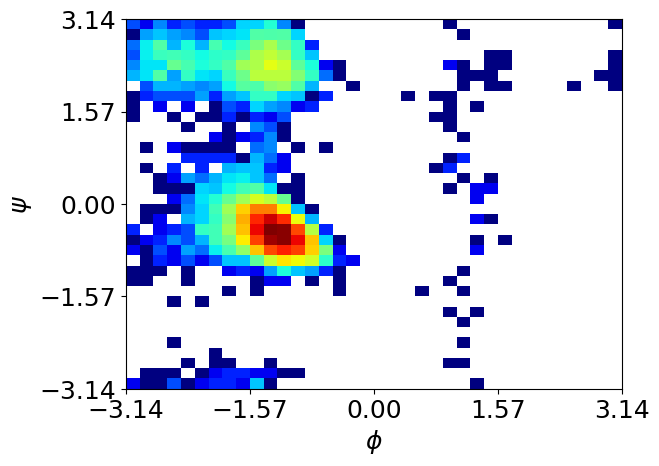

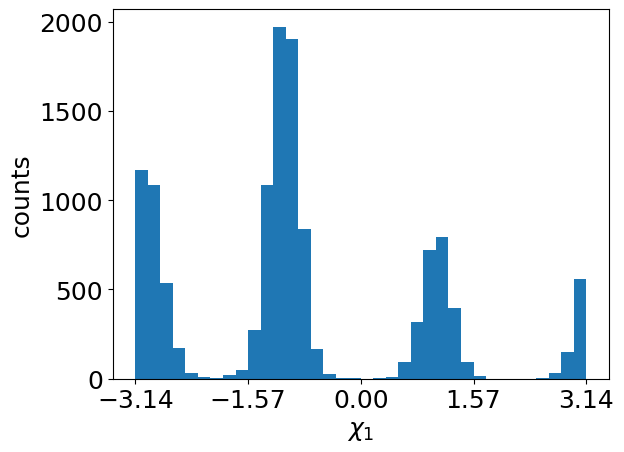

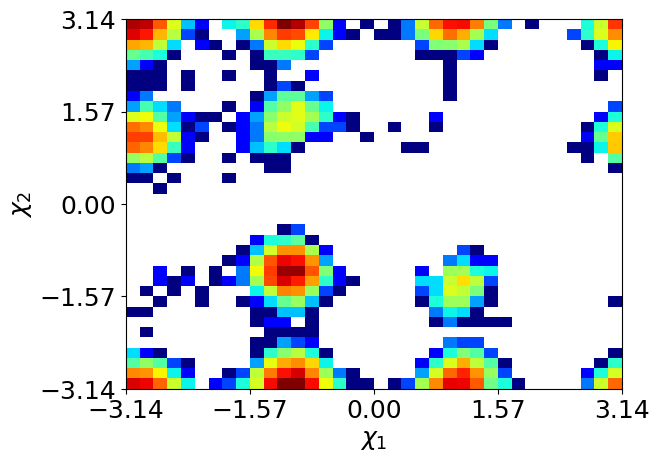

In [17]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [13]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [14]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 12559 frames, 35 atoms, 35 residues, and unitcells at 0x15a8acc50>

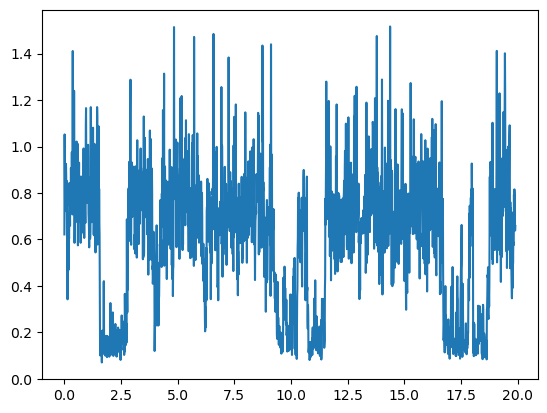

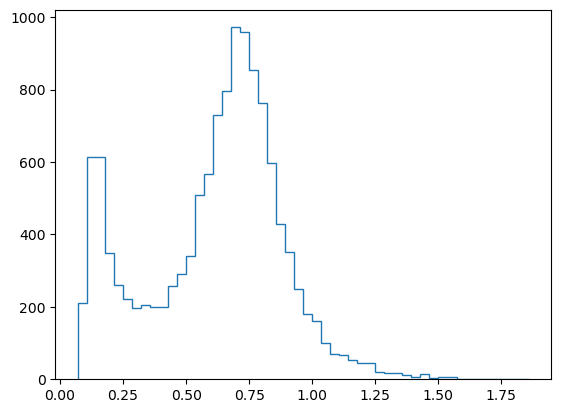

In [69]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

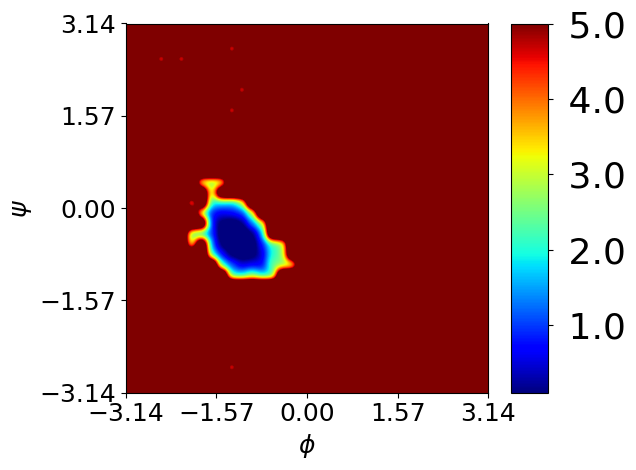

In [16]:
def plot_phipsi_FES_frames(res,frames):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res][frames],dihedral_dict['phi'][res][frames],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return


native_frames=np.where(rmsd<0.25)[0]
len(native_frames)
trj[native_frames].save_dcd(outdir+'native.dcd')

plot_phipsi_FES_frames(45,native_frames)


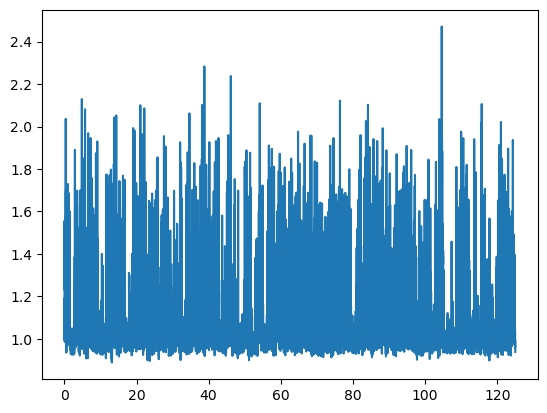

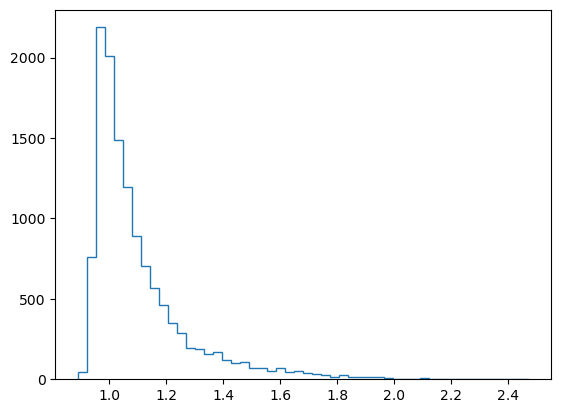

In [17]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [18]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(12559, 2)


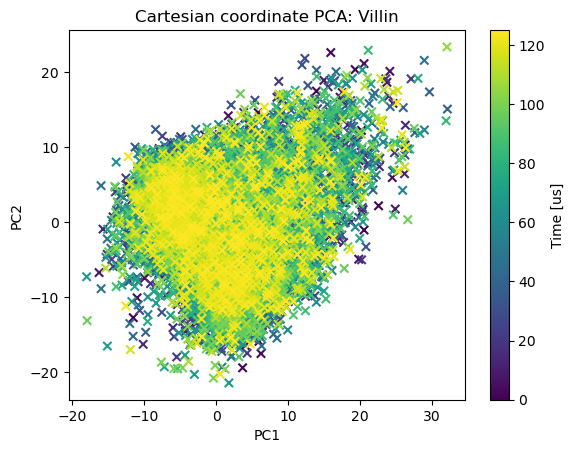

In [19]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

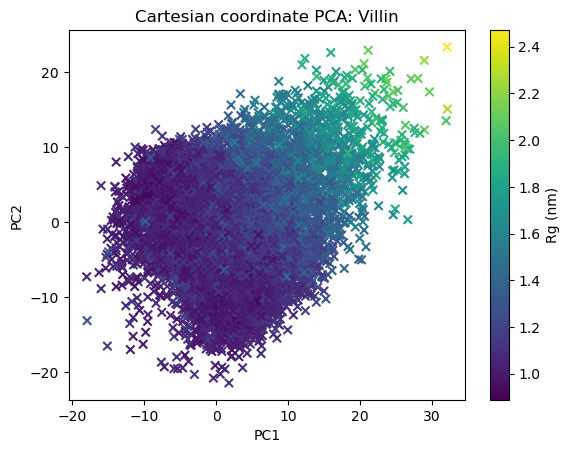

In [20]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

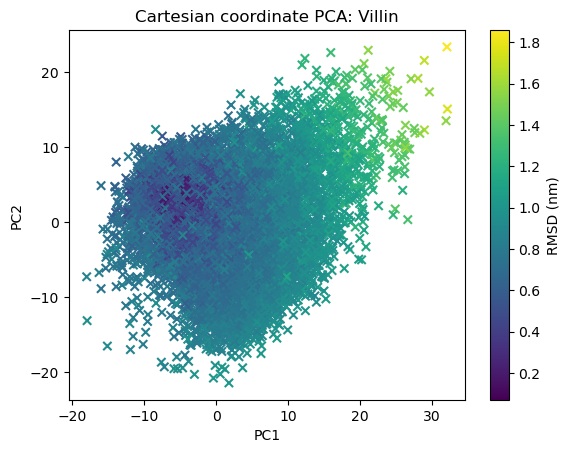

In [21]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

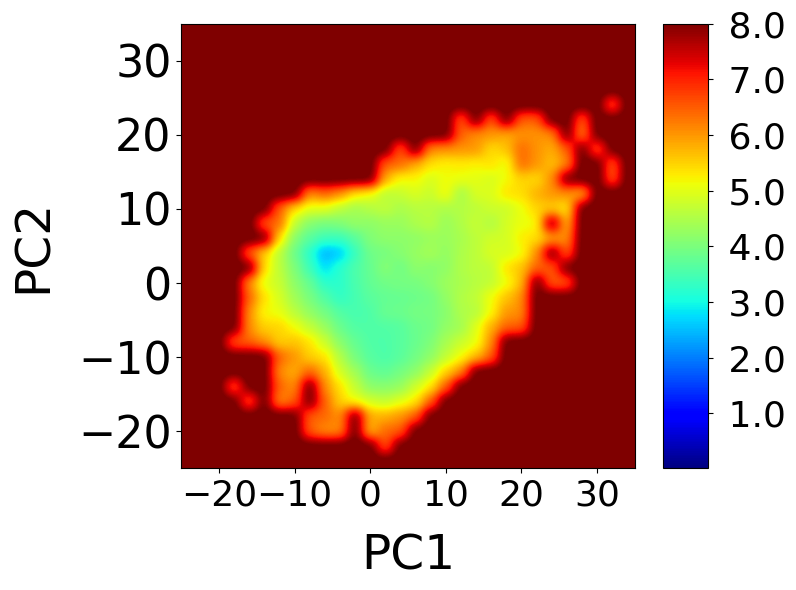

In [27]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [22]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters



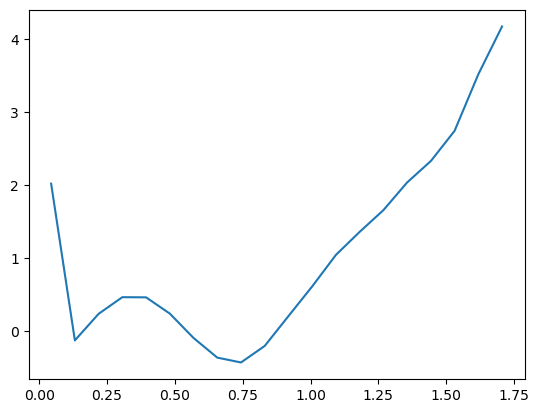

In [23]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)

In [24]:
#Possible Homework Prompt:
#Visualize the lowest free energy basin
basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))[0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

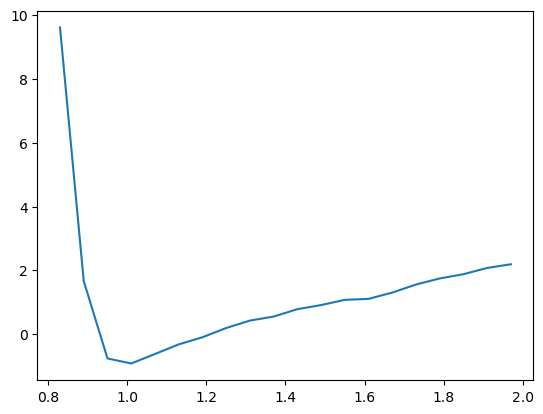

In [25]:
dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)

plt.plot(xedges,dG_rg)

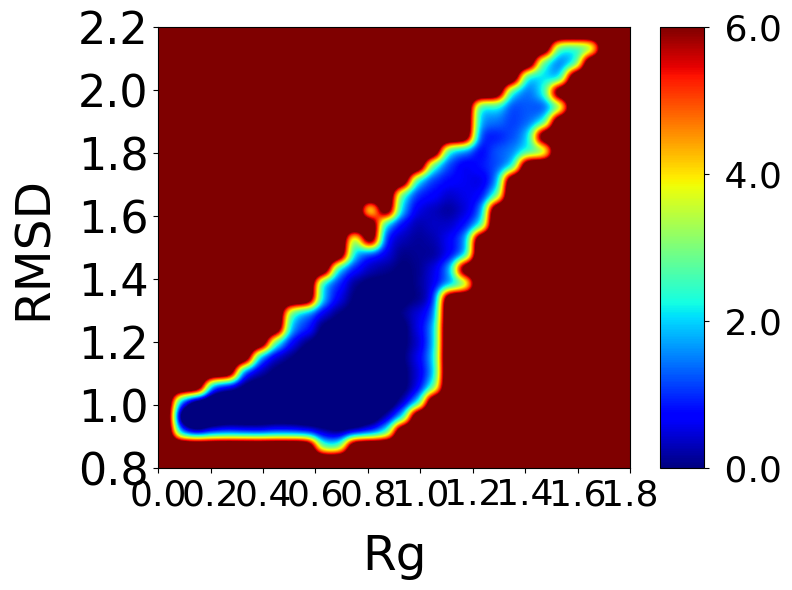

In [28]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

In [ ]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [29]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

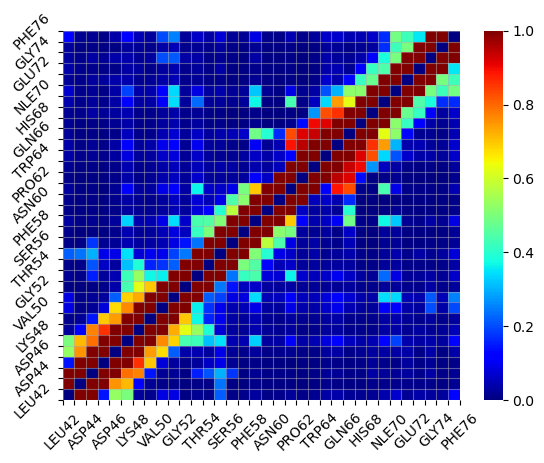

In [44]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

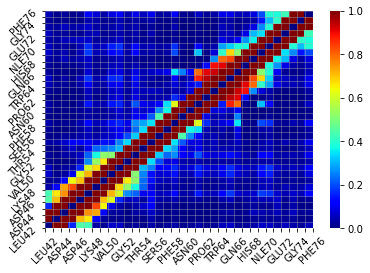

In [70]:
#Lets Make a Contact Map of the low dG Basin 
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[basin_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

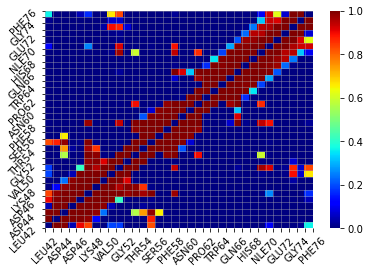

In [71]:
#Lets Make a Contact Map of the native frames
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[native_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [30]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [32]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_cor_map)

(33, 33)

In [33]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

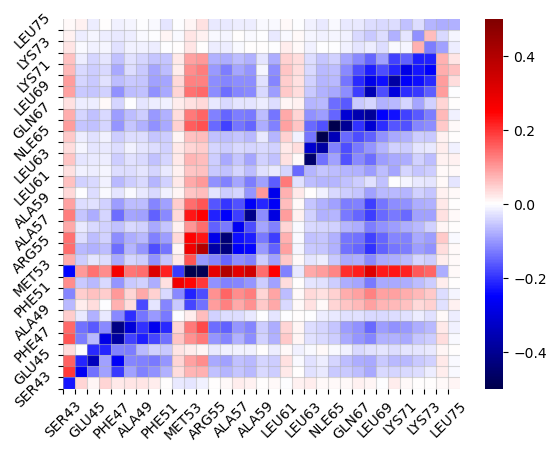

In [35]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

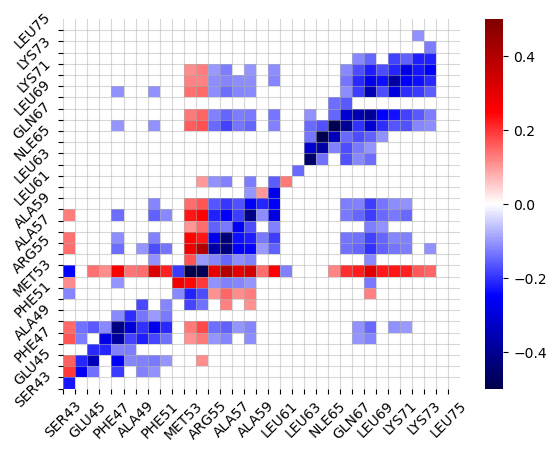

In [36]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

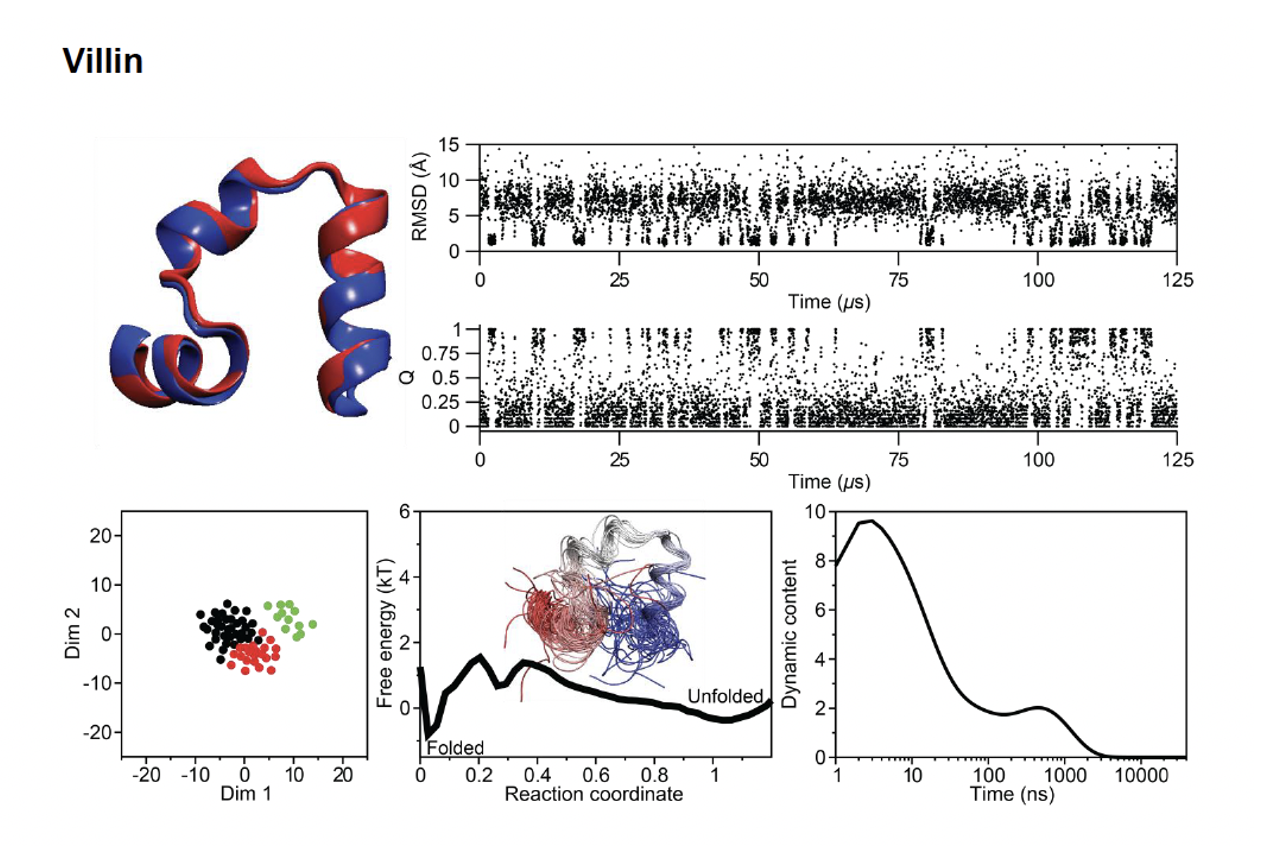

First we need to determine the native contacts and calculate Q

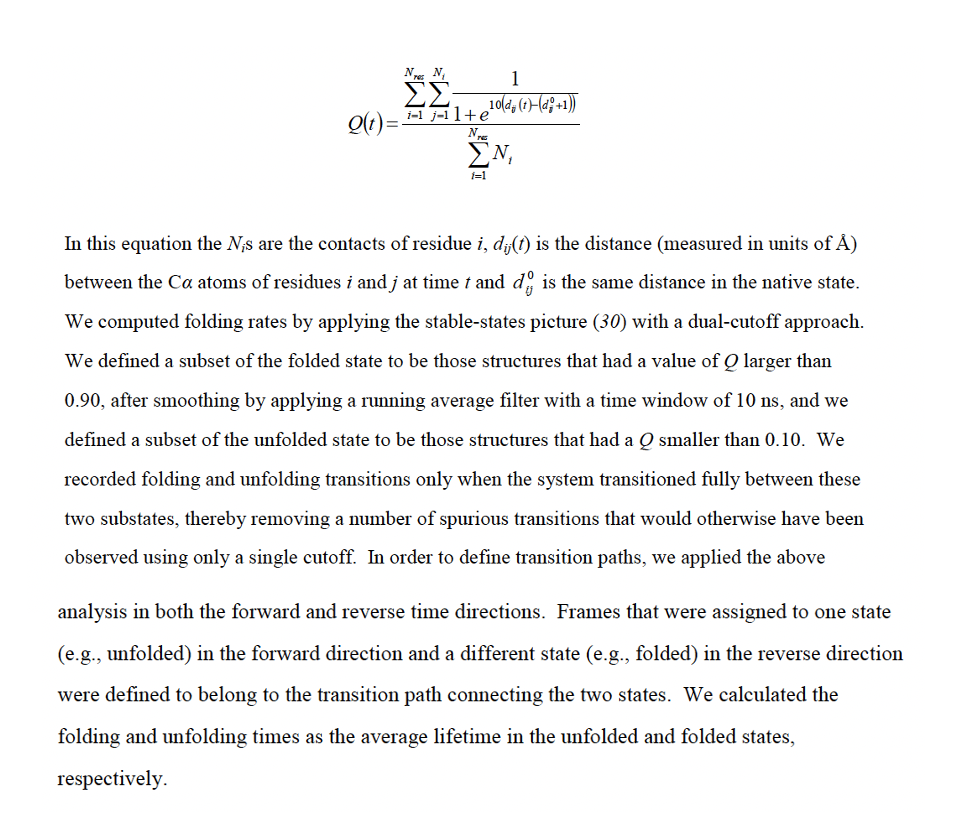

In [37]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x15a4d31d0>

In [38]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [39]:
Native_Contacts=np.where(native_distance_matrix1D<10)
Native_Contact_Distances=native_distance_matrix1D[Native_Contacts]
np.shape(Native_Contact_Distances)

(148,)

In [40]:
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[Native_Contacts]


In [41]:
np.shape(Traj_Native_Contact_Distances)

(148, 12559)

In [42]:
for i in range(0,len(Native_Contact_Distances)):
  print(Native_Contact_Distances[i],Traj_Native_Contact_Distances[i])

9.288557 [16.155031 14.692731 10.791452 ... 13.44309  11.834915 12.631355]
9.985726 [11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006]
9.704253 [11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935]
9.60349 [ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ]
7.0967283 [ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226]
7.0852814 [10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863]
9.99271 [13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ]
9.574567 [12.595353  16.094152  12.5168705 ...  8.90573    9.433759   9.204168 ]
8.303897 [11.918608 14.237659 15.800192 ...  6.660173  8.140754  7.861574]
9.653462 [13.711605  13.591568  17.694164  ...  7.4799404  9.589137   8.898192 ]
9.792494 [17.497013 16.80119  20.938164 ... 10.491154 12.478381 12.31331 ]
9.633482 [12.349012 15.875407 14.908751 ...  8.254533  8.746978  8.578752]
7.2052145 [18.622604 18.50881  19.704548 ... 11.794368 12.8717   12.52

In [43]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_Native_Contact_Distances))
for i in range(0,len(Native_Contact_Distances)):
 Native_Contact_Distances_nframes[i]=Native_Contact_Distances[i]

In [45]:
np.shape(Native_Contact_Distances_nframes)

(148, 12559)

In [94]:
for i in range(0,46):
    print(Native_Contacts_Xray_Dist[i],Native_Contacts_Trj_Dist[i])

9.985726 [11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006]
10.452459 [ 9.374432 15.550833 18.456451 ...  9.84092   8.556069  8.788097]
9.704253 [11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935]
9.60349 [ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ]
7.0967283 [ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226]
7.0852814 [10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863]
9.99271 [13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ]
9.574567 [12.595353  16.094152  12.5168705 ...  8.90573    9.433759   9.204168 ]
8.303897 [11.918608 14.237659 15.800192 ...  6.660173  8.140754  7.861574]
9.653462 [13.711605  13.591568  17.694164  ...  7.4799404  9.589137   8.898192 ]
9.633482 [12.349012 15.875407 14.908751 ...  8.254533  8.746978  8.578752]
10.225195 [14.985344 15.004972 16.675589 ...  8.071144  9.364284  8.658443]
6.8318415 [12.484558  12.280922  14.192814  ...  5.4976153  6.584661

In [95]:
Xray_Distance_Expand=np.zeros(np.shape(Native_Contacts_Trj_Dist))
for i in range(0,len(Native_Contacts_Trj_Dist)):
    Xray_Distance_Expand[i,:]=Native_Contacts_Xray_Dist[i]
    
Xray_Distance_Expand

array([[ 9.98572636,  9.98572636,  9.98572636, ...,  9.98572636,
         9.98572636,  9.98572636],
       [10.45245934, 10.45245934, 10.45245934, ..., 10.45245934,
        10.45245934, 10.45245934],
       [ 9.7042532 ,  9.7042532 ,  9.7042532 , ...,  9.7042532 ,
         9.7042532 ,  9.7042532 ],
       ...,
       [ 7.79883337,  7.79883337,  7.79883337, ...,  7.79883337,
         7.79883337,  7.79883337],
       [ 9.57147789,  9.57147789,  9.57147789, ...,  9.57147789,
         9.57147789,  9.57147789],
       [ 9.69182968,  9.69182968,  9.69182968, ...,  9.69182968,
         9.69182968,  9.69182968]])

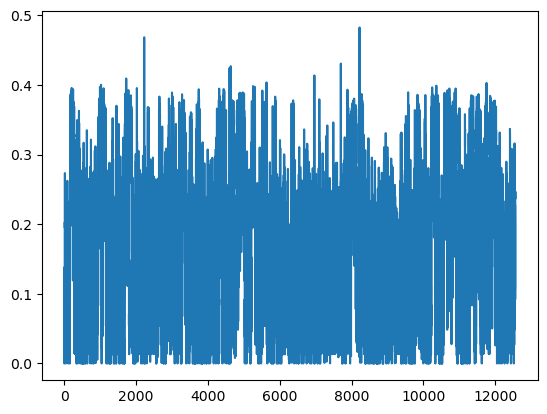

(array([2.180e+03, 3.015e+03, 1.938e+03, 1.337e+03, 9.330e+02, 9.600e+02,
        1.155e+03, 9.890e+02, 5.000e+01, 2.000e+00]),
 array([4.14158065e-30, 4.82478970e-02, 9.64957939e-02, 1.44743691e-01,
        1.92991588e-01, 2.41239485e-01, 2.89487382e-01, 3.37735279e-01,
        3.85983176e-01, 4.34231073e-01, 4.82478970e-01]),
 [<matplotlib.patches.Polygon at 0x18b37fb10>])

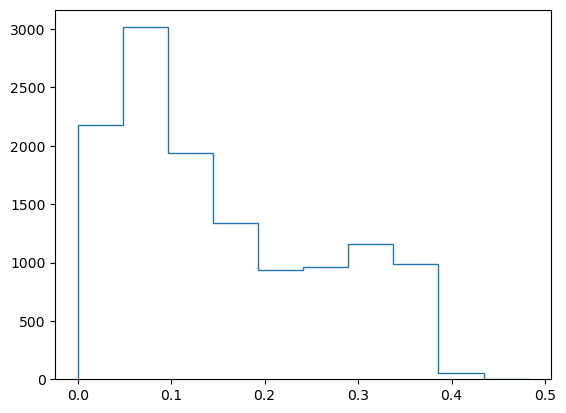

In [49]:
Q=1/(1+np.exp(10*(Traj_Native_Contact_Distances-(Native_Contact_Distances_nframes+1))))

Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_Contact_Distances)
plt.plot(Q)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')

In [48]:
#Now Lets Consider a "Native Portion of the Trajectory"
native_frames

array([  158,   159,   160, ..., 12022, 12023, 12027])

In [50]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [51]:
np.shape(native_distance_matrix1D)

(702,)

In [52]:
np.shape(traj_CA_distance_matrix1D)

(702, 12559)

In [53]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 2054)

In [54]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 521, 550,
       557, 569, 570, 635, 636, 684, 701])

In [55]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(46, 12559)

In [56]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i])

9.985726 [11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006]
10.452459 [ 9.374432 15.550833 18.456451 ...  9.84092   8.556069  8.788097]
9.704253 [11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935]
9.60349 [ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ]
7.0967283 [ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226]
7.0852814 [10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863]
9.99271 [13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ]
9.574567 [12.595353  16.094152  12.5168705 ...  8.90573    9.433759   9.204168 ]
8.303897 [11.918608 14.237659 15.800192 ...  6.660173  8.140754  7.861574]
9.653462 [13.711605  13.591568  17.694164  ...  7.4799404  9.589137   8.898192 ]
9.633482 [12.349012 15.875407 14.908751 ...  8.254533  8.746978  8.578752]
10.225195 [14.985344 15.004972 16.675589 ...  8.071144  9.364284  8.658443]
6.8318415 [12.484558  12.280922  14.192814  ...  5.4976153  6.584661

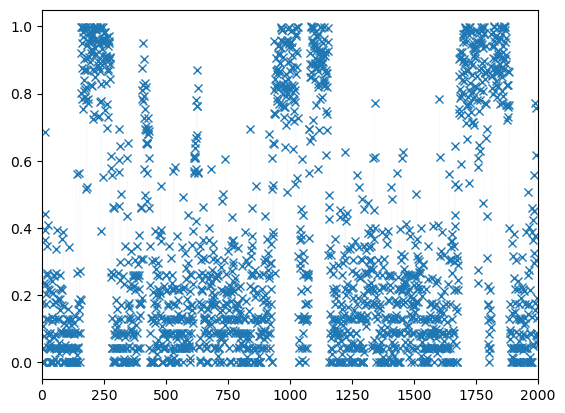

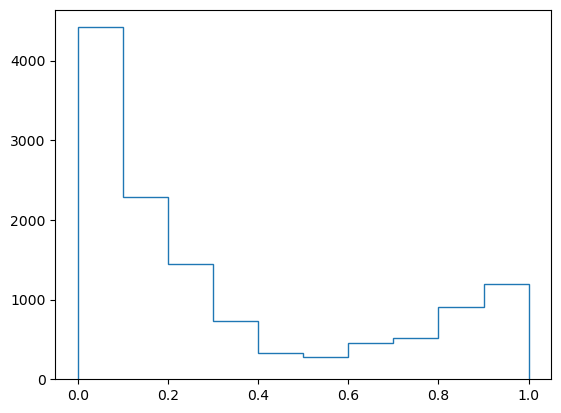

In [57]:
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

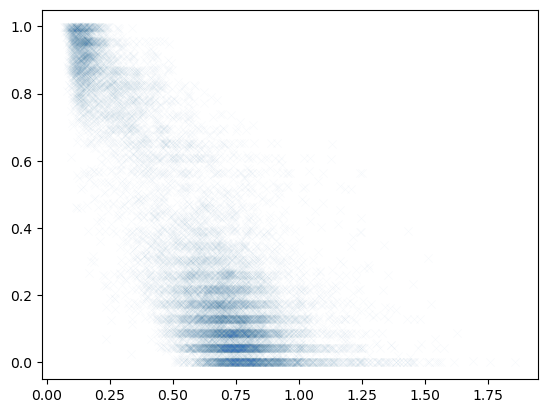

In [58]:
#Plot Q and a Histogram
plt.scatter(rmsd,Q,marker='x',linewidth=.01)

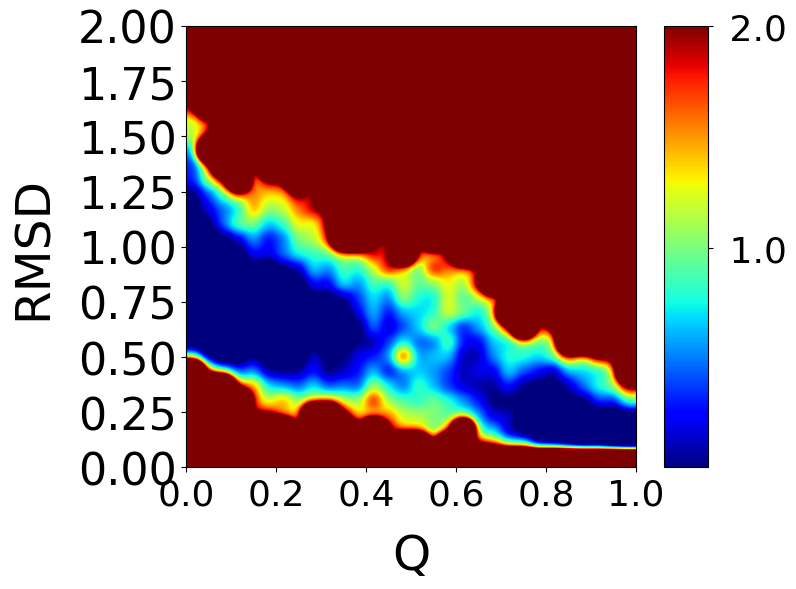

In [59]:
dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.tight_layout()

Text(0, 0.5, '$\\Delta$G')

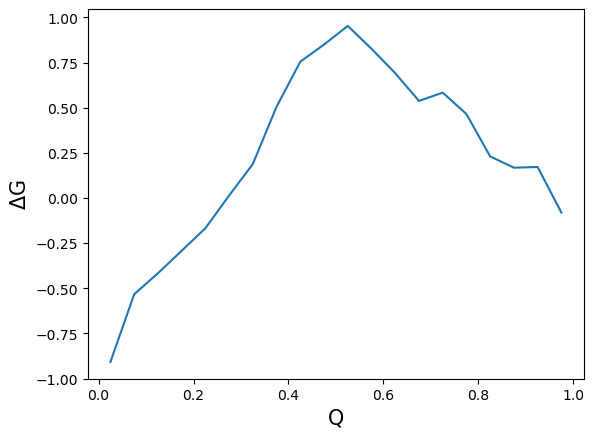

In [60]:
dG_Q,xedges=free_energy1D(Q,300,0,1,20)

plt.plot(xedges,dG_Q)
plt.xlabel("Q",size=15)
plt.ylabel("$\Delta$G",size=15)

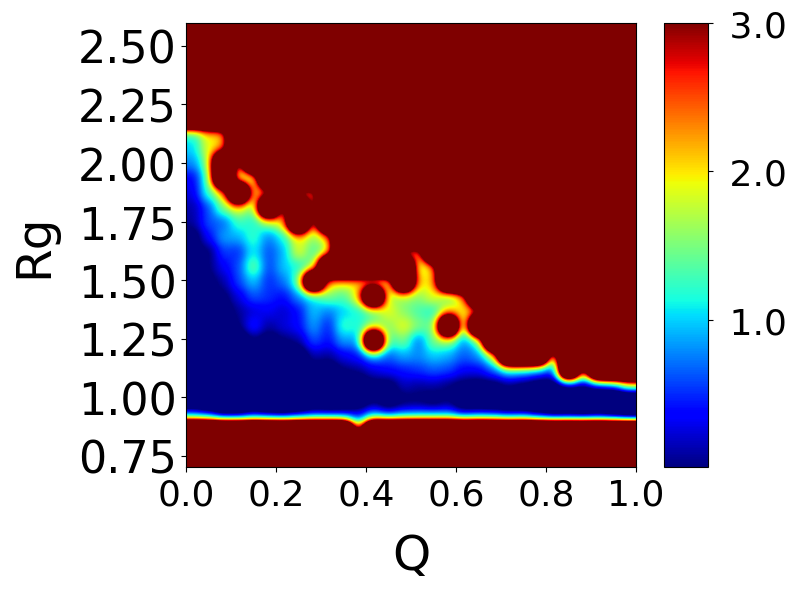

In [61]:
dG,xedges,yedges=free_energy(rg, Q, 300, 0.7, 2.6, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2,3]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()

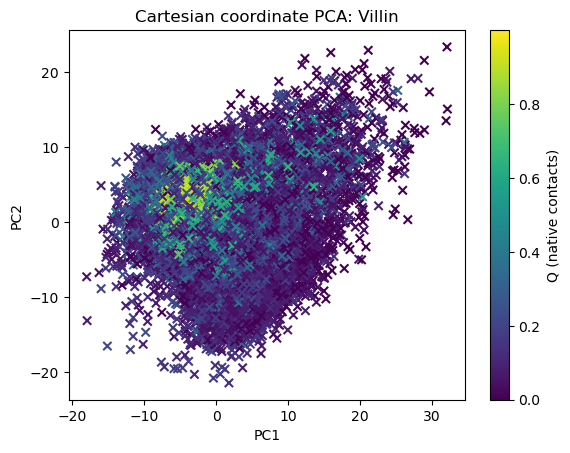

In [62]:
### plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=Q)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Q (native contacts)')

For Project 4:
The only required task is using the dual-cutoff approach describe in the SI of "How Fast Folding Proteins Fold". To calculate the locations of transition paths in the trajectory & compute something about transition states (helical content, distance between key native contacts) and demonstrate how it compares to the unfolded state.
If you're going for the HP/A:  Pose a mechanistic/temporal question about transition paths (does this happen before this, etc.) or plot some Transition paths and a free energy surface of your choosing.   Maybe plot some long vs. short TPs?

My Answer for Project 4: I used the dual cutoff approach to find the transition paths. I initially tried both Q and rmsd before settling on the rmsd method since the plot looked less noisy than for Q. I followed the SI description of how to cutoff from 0.25 to 0.8 rmsd transitions in both passing directions. I hen extracted these frames as transition paths. I compared the helical content between transition paths and folded/unfolded states, as well as percent native contacts. For my extension I compared the lengths of transition paths using a histogram and I also created a function to plot the formation of helices across a transition path for a given path.

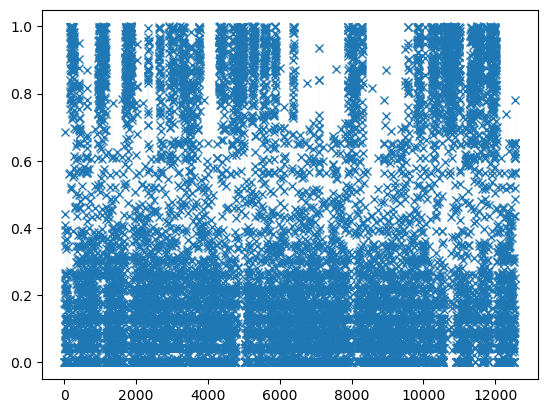

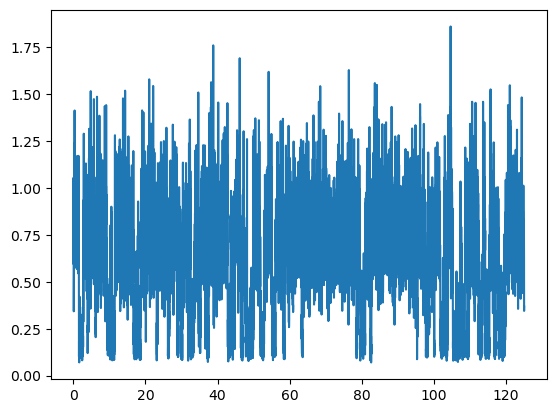

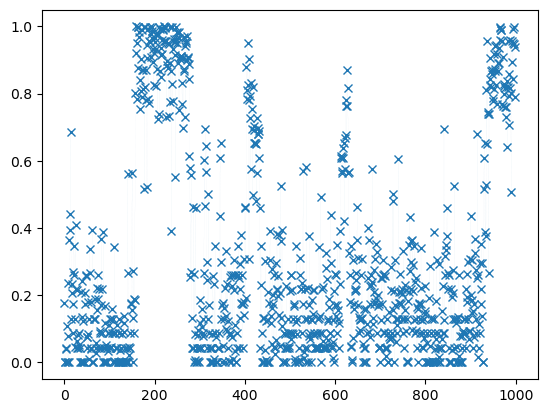

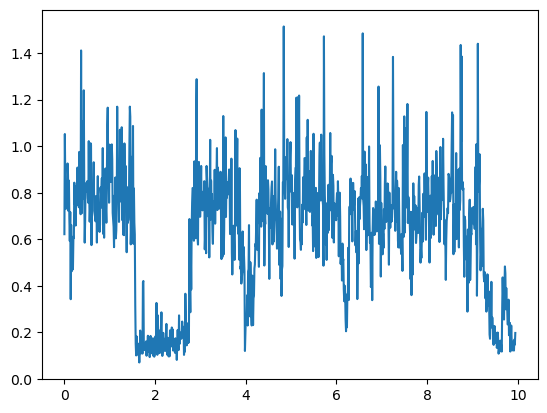

<Figure size 640x480 with 0 Axes>

In [80]:
#Observing Distribution of Q and rmsd values over time
plt.plot(Q,marker='x',linewidth=.01)
plt.show()
plt.clf()
plt.plot(time,rmsd)
plt.show()
plt.clf()
plt.plot(Q[:1000],marker='x',linewidth=.01)
plt.show()
plt.clf()
plt.plot(time[:1000],rmsd[:1000])
plt.show()
plt.clf()

In [89]:
#Applyting window function to smooth results
from scipy.ndimage import uniform_filter1d

N = 5
smoothQ = uniform_filter1d(Q, size=N)
smoothrmsd = uniform_filter1d(rmsd, size=N)

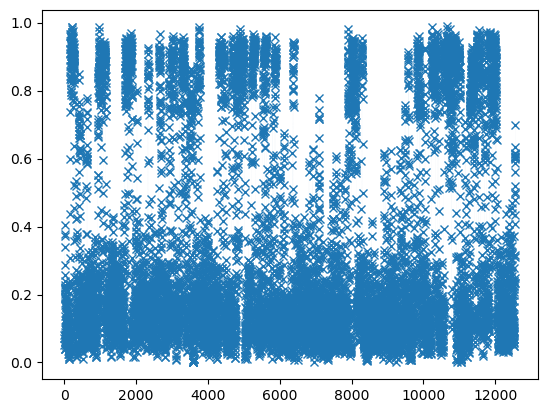

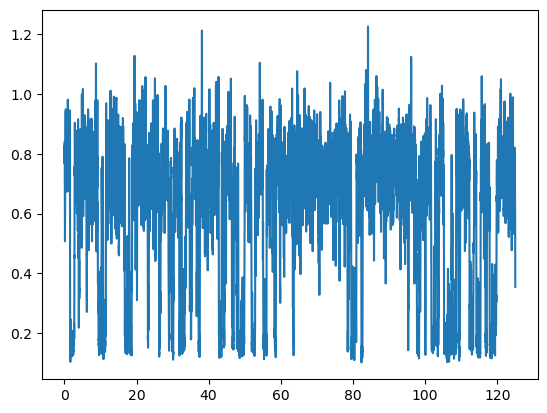

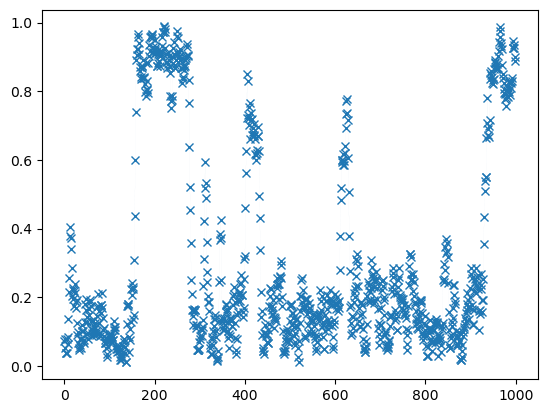

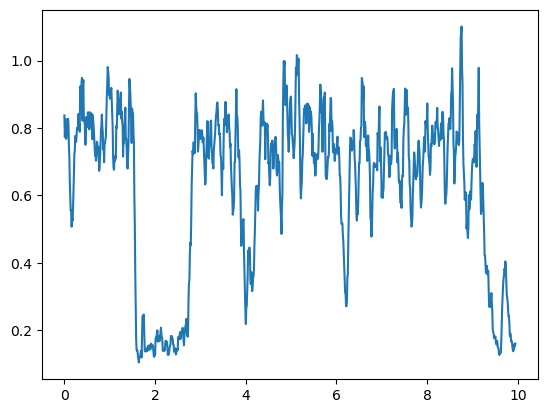

<Figure size 640x480 with 0 Axes>

In [90]:
plt.plot(smoothQ,marker='x',linewidth=.01)
plt.show()
plt.clf()
plt.plot(time,smoothrmsd)
plt.show()
plt.clf()
plt.plot(smoothQ[:1000],marker='x',linewidth=.01)
plt.show()
plt.clf()
plt.plot(time[:1000],smoothrmsd[:1000])
plt.show()
plt.clf()

In [104]:
#Dual cutoff approach to find transition paths using rmsd
folding = np.zeros_like(smoothrmsd)
folded = np.zeros_like(smoothrmsd)
isfolding = False
for i in range(len(folding)):
  if smoothrmsd[i] > 0.8:
    isfolding = True
  elif smoothrmsd[i] < 0.25:
    folded[i] = 1
    isfolding = False
  if isfolding:
    folding[i] = 1

isunfolding = False
for i in range(len(folding)):
  if smoothrmsd[len(folding) -i - 1] < 0.25:
    isunfolding = True
  elif smoothrmsd[len(folding) -i - 1] > 0.8:
    isunfolding = False
  if not isunfolding:
    folding[len(folding) -i - 1] = 0
    
print(np.sum(folding))


624.0


Text(0.5, 0, 'Time')

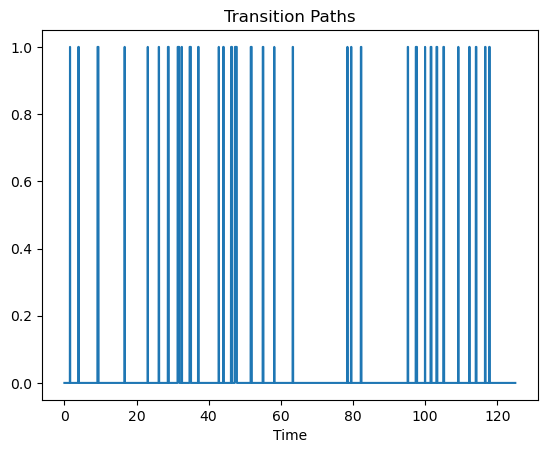

In [108]:
plt.plot(time,folding)
plt.title("Transition Paths")
plt.xlabel("Time")

In [122]:
transition = np.where(folding)[0]
print("These are the transition path frames:", transition)
unfolded = np.where(smoothrmsd > 0.8)[0]
folded = np.where(smoothrmsd < 0.25)[0]

These are the transition path frames: [  153   154   155   156   157   158   385   386   387   388   389   390
   391   392   393   394   395   396   397   398   399   400   401   920
   921   922   923   924   925   926   927   928   929   930   931   932
   933   934   935   936   937   938   939   940   941   942   943   944
   945   946   947   948  1674  1675  1676  1677  1678  1679  1680  1681
  2318  2319  2320  2321  2322  2323  2324  2625  2626  2627  2628  2629
  2630  2631  2632  2633  2634  2635  2880  2881  2882  2883  2884  2885
  2886  2887  2888  2889  2890  2891  2892  2893  2894  2895  2896  2897
  2898  2899  2900  2901  2902  2903  2904  2905  3152  3153  3154  3155
  3156  3157  3158  3159  3160  3161  3162  3163  3164  3165  3166  3167
  3168  3169  3170  3171  3172  3173  3174  3175  3176  3177  3178  3179
  3180  3181  3182  3183  3184  3185  3186  3187  3188  3189  3190  3191
  3192  3193  3194  3195  3196  3197  3198  3199  3264  3265  3266  3267
  3268  3269 

In [121]:
#Counting the number of fully defined transition paths
paths = []
previous = -9999
path = []
for f in transition:
  if (f - previous ) != 1:
    if len(path) != 0:
      paths.append(path)
    path = [f]
  else:
    path.append(f)
  previous = f
    
print("Number of fully defined transition paths:", len(paths))
print("Paths:", paths)

Number of fully defined transition paths: 32
Paths: [[153, 154, 155, 156, 157, 158], [385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401], [920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948], [1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681], [2318, 2319, 2320, 2321, 2322, 2323, 2324], [2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635], [2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905], [3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199], [3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273], [3485, 34

In [ ]:
#Plotting formation of secondary structure
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

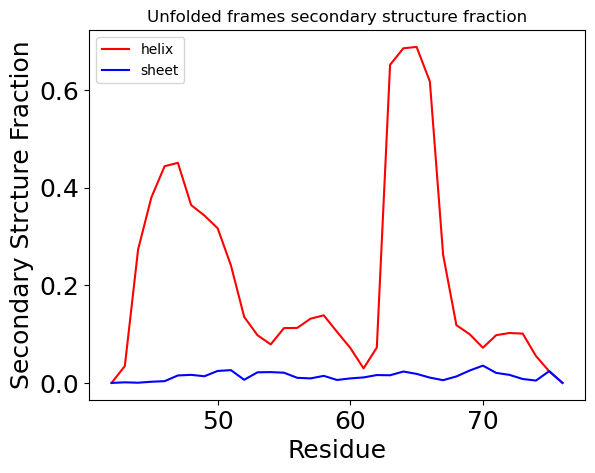

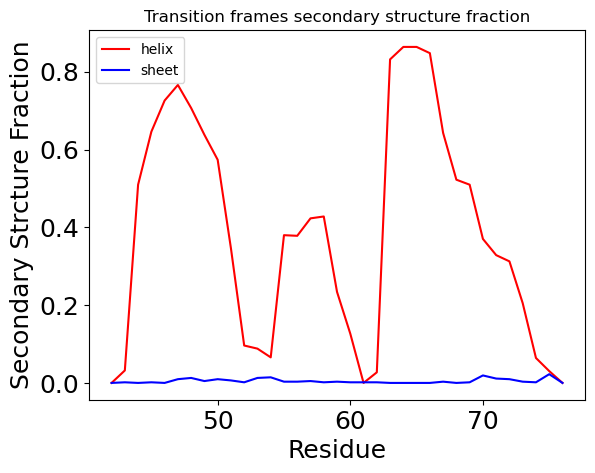

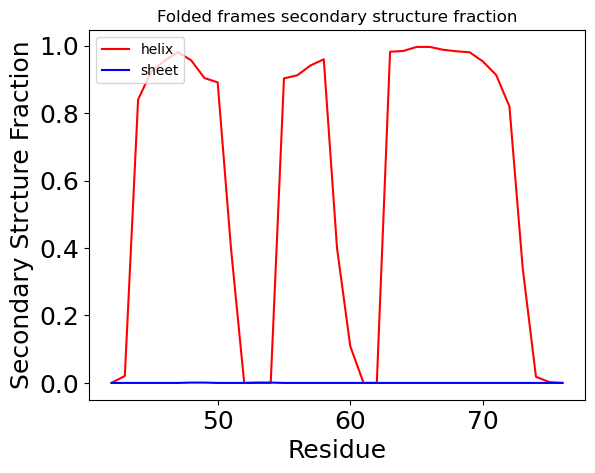

<Figure size 640x480 with 0 Axes>

In [135]:
dssp=md.compute_dssp(trjBB,simplified=True)

dssp_transition = dssp[transition]
dssp_folded = dssp[folded]
dssp_unfolded = dssp[unfolded]

Hprop,Eprop=dssp_convert(dssp_unfolded)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')
plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.title("Unfolded frames secondary structure fraction")
plt.tick_params(labelsize=18)
plt.show()
plt.clf()

Hprop,Eprop=dssp_convert(dssp_transition)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')
plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.title("Transition frames secondary structure fraction")
plt.tick_params(labelsize=18)
plt.show()
plt.clf()

Hprop,Eprop=dssp_convert(dssp_folded)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')
plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.title("Folded frames secondary structure fraction")
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
plt.show()
plt.clf()

In [142]:
#Percent Native contacts in tranistion frames
Q_transition = Q[transition]
Q_unfolded = Q[unfolded]
Q_folded = Q[folded]

print(np.mean(Q_unfolded), "Average native contacts in unfolded state")
print(np.mean(Q_transition), "Average native contacts in transition state")
print(np.mean(Q_folded), "Average native contacts in folded state")

0.10822846580367915 Average native contacts in unfolded state
0.3434326071497164 Average native contacts in transition state
0.8826945798584539 Average native contacts in folded state


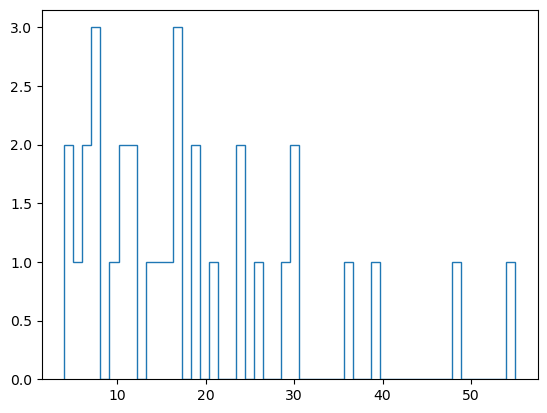

In [145]:
#Extension: Answering temporal questions
lengths = []
# comparing transition path lengths
for path in paths:
  lengths.append(len(path))
  
plt.hist(lengths,histtype='step',bins=50)
plt.show()

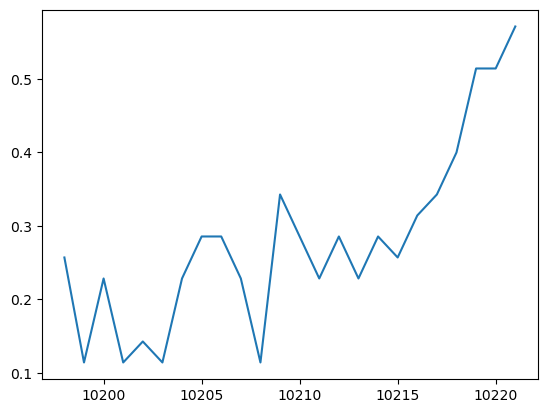

In [155]:
# secondary structure formation
path_num = 25
res
helixarray = []
for frame in paths[path_num]:
  helixarray.append((np.sum(dssp[frame] =='H')/len(dssp[400])))
  
plt.plot(paths[path_num],helixarray)
